# Analysis of Experimental Data - Measuring Drop Spreading Law

Edward Alexandroff <br>
January 2021

This notebook concerns analysis of experimental measurements of the time it takes for a small droplet of fluid to spread out as a function of radius. Over the course of this Jupyter notebook, we intend to determine which "spreading law" is best obeyed by these droplets.

This Jupyter notebook is adapted from the skeleton jupyter notebook created by Proffesor Draga Pihler-Puzovic, University of Manchester, for the Computational Physics Module (PHYS20762), January 2021. This notebook was submitted as a piece of coursework for that same course. 

## Initializing the Notebook

Let's first initialise our Python interpreter

In [14]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import random

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

## Experimental Data

This is data that we'll be working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [15]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

Let's plot this data to see what it looks like:

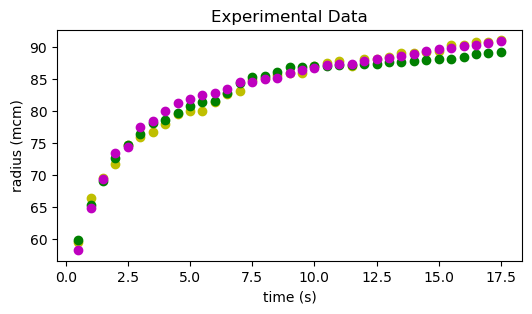

In [16]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
plt.plot(time, radius_data1, "yo")
plt.plot(time, radius_data2, "go")
plt.plot(time, radius_data3, "mo")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("radius (mcm)")
plt.title("Experimental Data")
# displaying the plot
plt.show()

Now let's estimate the mean and standard deviation of these values using the three experimental runs.

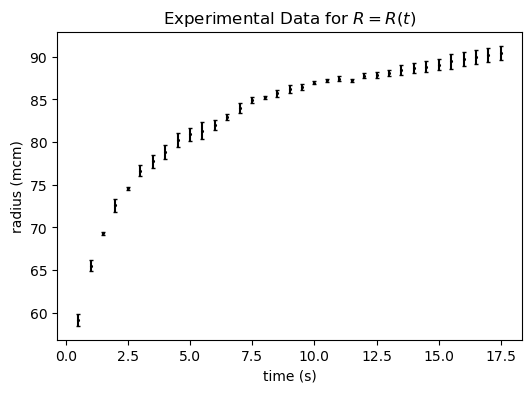

In [17]:
radius = np.array([radius_data1, radius_data2, radius_data3])

#calculating the mean R values as well as the associated errors
radius_mean = np.mean(radius, axis = 0)
radius_std = np.std(radius, axis = 0)

#PLotting the R vs time data
plt.rcParams["figure.figsize"] = (6,4)
plt.errorbar(time, radius_mean, yerr=radius_std, fmt='.', markersize=2.5, color='black', linestyle='', capsize=1.5)
plt.title(r'Experimental Data for $R = R(t)$')
plt.xlabel(r'time (s)')
plt.ylabel(r'radius (mcm)')

plt.show()

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

The spreading law is a relationship between the speed of the contact line ($U$) (essentially how fast the drop is spreading) and the contact angle ($\theta$) (the angle the surface of the drop makes with the surface at the boundary between the two). In order to determine the spreading law, we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ can be found.

In [18]:
# V in cubic micrometers:
V = 7.6 * (10 ** 3)

def speed_function(radius_data, time_data):
    """
    Calculates the values for the speed of the contact line, U, from R and t values using the equation detailed above
    
    Arguments: 
        radius_data (np array of floats)
        time_data (np array of floats)
    Returns:
        U_array (np array of floats)
    """
    U_array = np.empty([0, 1])
    
    for i in range(len(time_data) - 1):
        
        delta_t = np.array([time_data[i + 1] - time_data[i]])
        U_values = (radius_data[i + 1] - radius_data[i]) / delta_t
        
        U_array = np.vstack([U_array, U_values])
        
    return U_array

def theta_function(radius_data, time_data):
    """
    For each value of R, H is calculated by rearranging the volume formula given above into a polynomial in H and solving for 
    H (considering only positive H) using fsolve. Then for each pair of R and H, theta is calculated using the formula above.
    
    Arguments:
        radius_data (np array of floats)
        time_data (np array of floats)
    Returns:
        theta_array (np array of floats)
    """
    theta_array = np.empty([0, 1])
    
    for i in range(len(radius_data) - 1):
        
        H_value = fsolve(lambda x: np.polyval([1, 0, 3 * radius_data[i] ** 2, (-6 * V) / np.pi], x), x0=0.75, 
                          xtol=1 * 10 ** -5)
        
        temp = (radius_data[i] ** 2 - H_value ** 2) / (2 * H_value * radius_data[i])
        theta_value = np.pi/2 - np.arctan(temp)
        
        theta_array = np.vstack([theta_array, theta_value])
    
    return theta_array

def theta_and_U_data(radius_data, time_data):
    """
    Using speed_function and theta_function, calculates the theta and U values for a given trial, and combines 
    them into one array using np.hstack.
    
    Arguments: 
        radius_data (np array of floats)
        time_data (np array of floats)
    Returns:
        theta_and_U (np array of floats)
    """
    U_array = speed_function(radius_data, time_data)
    theta_array = theta_function(radius_data, time_data)
    
    theta_and_U = np.hstack([theta_array, U_array])
    
    return theta_and_U

#Finding $\theta$ and U data for each trial. First column of array being theta values, and second being U values

theta_and_U1 = theta_and_U_data(radius_data1, time)
theta_and_U2 = theta_and_U_data(radius_data2, time)
theta_and_U3 = theta_and_U_data(radius_data3, time)

Let's plot these results to see what they look like:

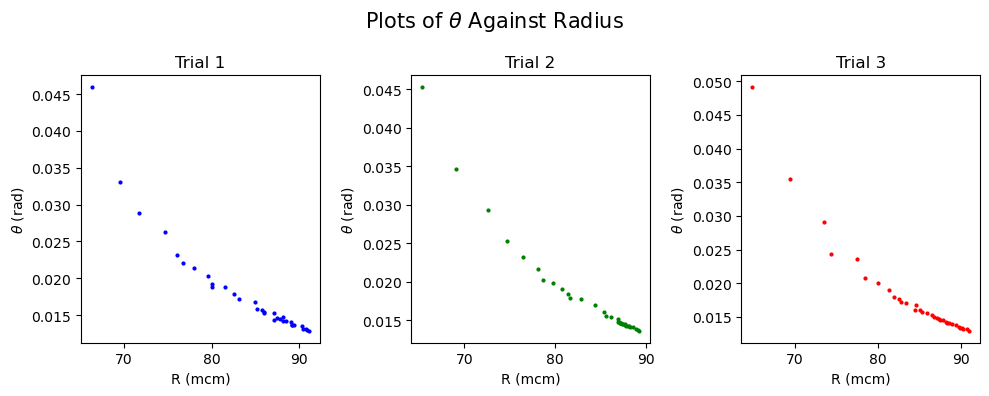

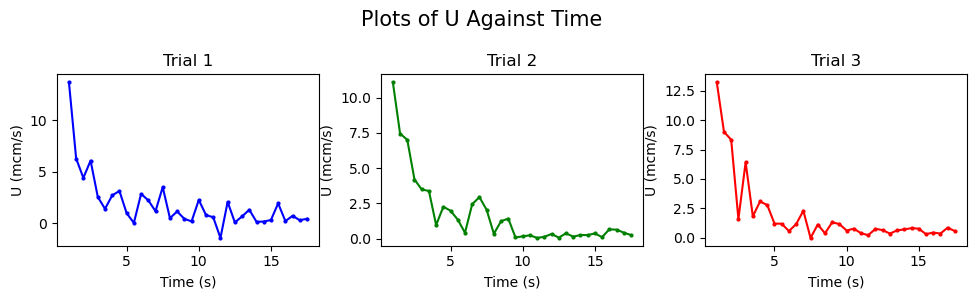

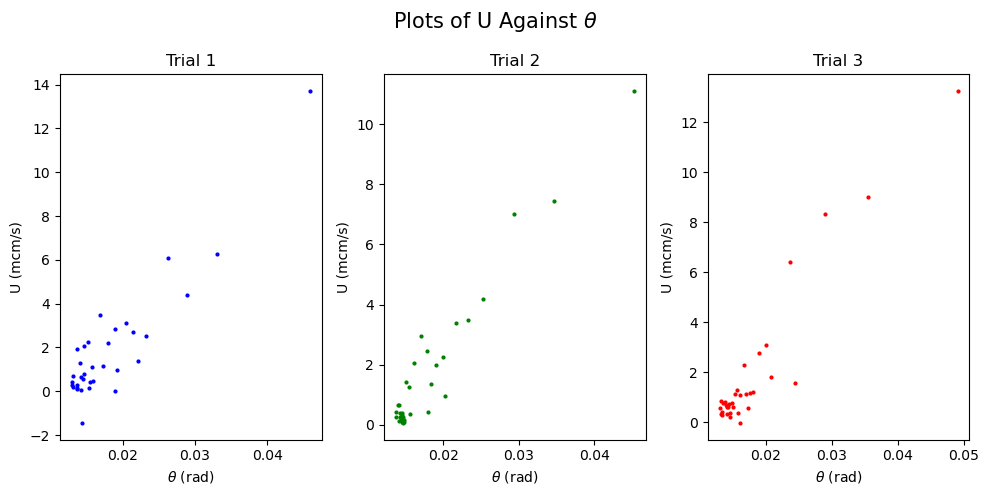

In [19]:
#Plots of $\theta$ against R for each trial:

plt.rcParams["figure.figsize"] = (10, 4)
figure = plt.figure()
figure.suptitle(r'Plots of $\theta$ Against Radius', fontsize=15)

r_theta_plot1 = figure.add_subplot(131)
r_theta_plot1.set_title(r'Trial 1')
r_theta_plot1.set_xlabel(r'R (mcm)')
r_theta_plot1.set_ylabel(r'$\theta$ (rad)')
r_theta_scatter1 = r_theta_plot1.plot(radius_data1[1:], theta_and_U1[:, 0], marker='o', markersize=2, color='blue', 
                                      linestyle='')

r_theta_plot2 = figure.add_subplot(132)
r_theta_plot2.set_title(r'Trial 2')
r_theta_plot2.set_xlabel(r'R (mcm)')
r_theta_plot2.set_ylabel(r'$\theta$ (rad)')
r_theta_scatter2 = r_theta_plot2.plot(radius_data2[1:], theta_and_U2[:, 0], marker='o', markersize=2, color='green', 
                                      linestyle='')

r_theta_plot3 = figure.add_subplot(133)
r_theta_plot3.set_title(r'Trial 3')
r_theta_plot3.set_xlabel(r'R (mcm)')
r_theta_plot3.set_ylabel(r'$\theta$ (rad)')
r_theta_scatter3 = r_theta_plot3.plot(radius_data3[1:], theta_and_U3[:, 0], marker='o', markersize=2, color='red', 
                                      linestyle='')

plt.tight_layout()
plt.show()

#Plots of U against time for each trial:

plt.rcParams["figure.figsize"] = (10, 3)
figure = plt.figure()
figure.suptitle(r'Plots of U Against Time', fontsize=15)

U_time_plot1 = figure.add_subplot(131)
U_time_plot1.set_title(r'Trial 1')
U_time_plot1.set_xlabel(r'Time (s)')
U_time_plot1.set_ylabel(r'U (mcm/s)')
U_time_scatter1 = U_time_plot1.plot(time[1:], theta_and_U1[:, 1], marker='o', markersize=2, color='blue')

U_time_plot2 = figure.add_subplot(132)
U_time_plot2.set_title(r'Trial 2')
U_time_plot2.set_xlabel(r'Time (s)')
U_time_plot2.set_ylabel(r'U (mcm/s)')
U_time_scatter2 = U_time_plot2.plot(time[1:], theta_and_U2[:, 1], marker='o', markersize=2, color='green')

U_time_plot3 = figure.add_subplot(133)
U_time_plot3.set_title(r'Trial 3')
U_time_plot3.set_xlabel(r'Time (s)')
U_time_plot3.set_ylabel(r'U (mcm/s)')
U_time_scatter3 = U_time_plot3.plot(time[1:], theta_and_U3[:, 1], marker='o', markersize=2, color='red')

plt.tight_layout()
plt.show()

#Plots of U vs theta for each trial:

plt.rcParams["figure.figsize"] = (10, 5)
figure = plt.figure()
figure.suptitle(r'Plots of U Against $\theta$', fontsize=15)

U_theta_plot1 = figure.add_subplot(131)
U_theta_plot1.set_title(r'Trial 1')
U_theta_plot1.set_xlabel(r'$\theta$ (rad)')
U_theta_plot1.set_ylabel(r'U (mcm/s)')
U_theta_scatter1 = U_theta_plot1.plot(theta_and_U1[:, 0], theta_and_U1[:, 1], marker='o', markersize=2, color='blue', 
                                      linestyle='')

U_theta_plot2 = figure.add_subplot(132)
U_theta_plot2.set_title(r'Trial 2')
U_theta_plot2.set_xlabel(r'$\theta$ (rad)')
U_theta_plot2.set_ylabel(r'U (mcm/s)')
U_theta_scatter2 = U_theta_plot2.plot(theta_and_U2[:, 0], theta_and_U2[:, 1], marker='o', markersize=2, color='green', 
                                      linestyle='')

U_theta_plot3 = figure.add_subplot(133)
U_theta_plot3.set_title(r'Trial 3')
U_theta_plot3.set_xlabel(r'$\theta$ (rad)')
U_theta_plot3.set_ylabel(r'U (mcm/s)')
U_theta_scatter3 = U_theta_plot3.plot(theta_and_U3[:, 0], theta_and_U3[:, 1], marker='o', markersize=2, color='red', 
                                      linestyle='')

plt.tight_layout()
plt.show()

The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

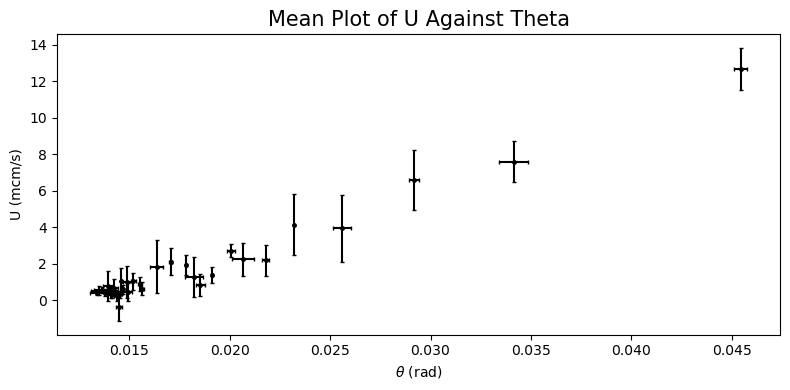

In [20]:
#Calculating mean and std's of $\theta$ and U
theta = np.array([theta_and_U1[:,0], theta_and_U2[:,0], theta_and_U2[:,0]])
theta_mean = np.mean(theta, axis = 0)
theta_std = np.std(theta, axis = 0)

U = np.array([theta_and_U1[:,1], theta_and_U2[:,1], theta_and_U3[:,1]])
U_mean = np.mean(U, axis = 0)
U_std = np.std(U, axis = 0)

#PLotting mean U against mean theta:

plt.rcParams["figure.figsize"] = (8,4)
figure = plt.figure()

U_theta_plot = figure.add_subplot()
U_theta_plot.set_title(r'Mean Plot of U Against Theta', fontsize=15)
U_theta_plot.set_xlabel(r'$\theta$ (rad)')
U_theta_plot.set_ylabel(r'U (mcm/s)')
U_theta_scatter = U_theta_plot.errorbar(theta_mean, U_mean, xerr=theta_std, yerr=U_std, fmt='o', markersize=2.5, color='black', 
                                        linestyle='', capsize=1.5)

plt.tight_layout()
plt.show()

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ plotted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be computed. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [21]:
def linear_fit (n):
    """
    Fits a linear relationship between theta_mean ** n and U_mean where n=3 corresponds to the Cox-Voinov Model, and n=2 
    corresponds to the de Gennes model. Calculates the U values of the fit, U_fit, as well as the 2 coefficients and their 
    errors, (where coef0 = U_0 and coef1 = -U_0 * $\theta$_0 ** n). Then calculates U_0 and theta_0 and their errors.
    
    Arguments:
        n (float, equals 2 or 3)
    Returns:
        fit_data (np array of floats)
    """
    #fitting the data to the model, finding U values given by the model, as well as error in U:
    
    (coef, covr) = np.polyfit(theta_mean ** n, U_mean, 1, cov=True)
    U_fit = np.polyval(coef, theta_mean ** n)
    err_U_fit = np.sqrt(np.sum(np.power(U_mean - U_fit, 2)) / (len(U_mean) - 2))
   
    #finding U_0 and $\theta$ and corresponding errors:
    
    U_0 = coef[0]
    #treat the case of n=2 and n=3 seperately due to how numpy handles cubic roots of negative floats
    if n==3:
        theta_0 = ((-1) ** n) * (np.absolute(coef[1] / U_0) ** (1 / n))
    else:
        theta_0 = (-coef[1] / U_0) ** (1 / n)
    
    err_coef0 = np.sqrt(covr[0][0])
    err_coef1 = np.sqrt(covr[1][1])
    err_U_0 = err_coef0
    #error in theta_0 as calculated in quadrature
    err_theta_0 = np.absolute((theta_0 / n) * np.sqrt((err_coef0 / coef[0]) ** 2 + (err_coef1 / coef[1]) ** 2))
    
    fit_data = np.array([U_fit, err_U_fit, U_0, err_U_0, theta_0, err_theta_0], dtype=object)
    
    return(fit_data)

cox_voinov = linear_fit(3)
de_gennes = linear_fit(2)

print('\nUsing the Cox-Voinov Model, it was found that U_0 = {:.0f} +- {:.0f} mcm/s and theta_0 = {:.4f} +- {:.4f} rad'.format(
      cox_voinov[2],cox_voinov[3], cox_voinov[4], cox_voinov[5]))
print('\nUsing the de Gennes Model, it was found that U_0 = {:.0f} +- {:.0f} mcm/s and theta_0 = {:.4f} +- {:.4f} rad'.format(
      de_gennes[2],de_gennes[3], de_gennes[4], de_gennes[5]))


Using the Cox-Voinov Model, it was found that U_0 = 146413 +- 8715 mcm/s and theta_0 = -0.0151 +- 0.0017 rad

Using the de Gennes Model, it was found that U_0 = 6922 +- 258 mcm/s and theta_0 = 0.0103 +- 0.0010 rad


## Displaying the corresponding fits  

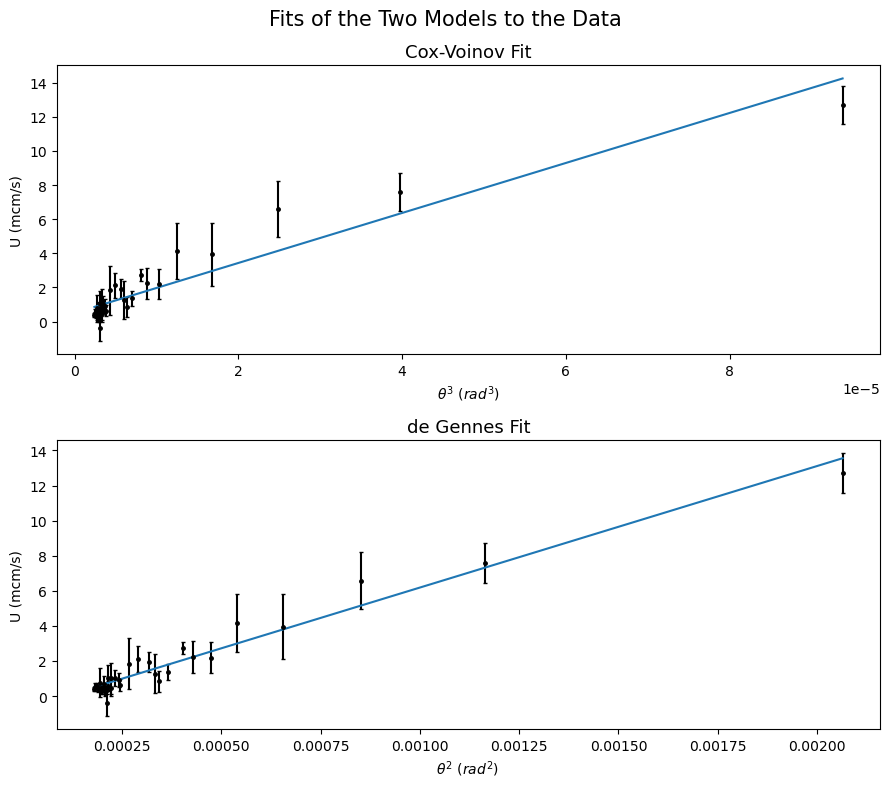

In [22]:
#Plots of the 2 fits overlayed on the raw data:

plt.rcParams["figure.figsize"] = (9, 8)
figure = plt.figure()
figure.suptitle(r'Fits of the Two Models to the Data', fontsize=15)

#Cox-Voinov model Plot:
cox_voinov_plot = figure.add_subplot(211)
cox_voinov_plot.set_title(r'Cox-Voinov Fit', fontsize=13)
cox_voinov_plot.set_xlabel(r'$\theta^{3} \ (rad^{3})$')
cox_voinov_plot.set_ylabel(r'U (mcm/s)')
cox_voinov_scatter = cox_voinov_plot.errorbar(theta_mean ** 3, U_mean, yerr=U_std, fmt='o', markersize=2.5, 
                                              color='black', linestyle='', capsize=1.5)
cox_voinov_model = cox_voinov_plot.plot(theta_mean ** 3, cox_voinov[0])

#de Gennes model plot
de_gennes_plot = figure.add_subplot(212)
de_gennes_plot.set_title(r'de Gennes Fit', fontsize=13)
de_gennes_plot.set_xlabel(r'$\theta^{2} \ (rad^{2})$ ')
de_gennes_plot.set_ylabel(r'U (mcm/s)')
de_gennes_scatter = de_gennes_plot.errorbar(theta_mean ** 2, U_mean, yerr=U_std, fmt='o', markersize=2.5, 
                                            color='black', linestyle='', capsize=1.5)
de_gennes_model = de_gennes_plot.plot(theta_mean ** 2, de_gennes[0])

plt.tight_layout()
plt.show()

![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. The case is further strengthened using the residual plots. 

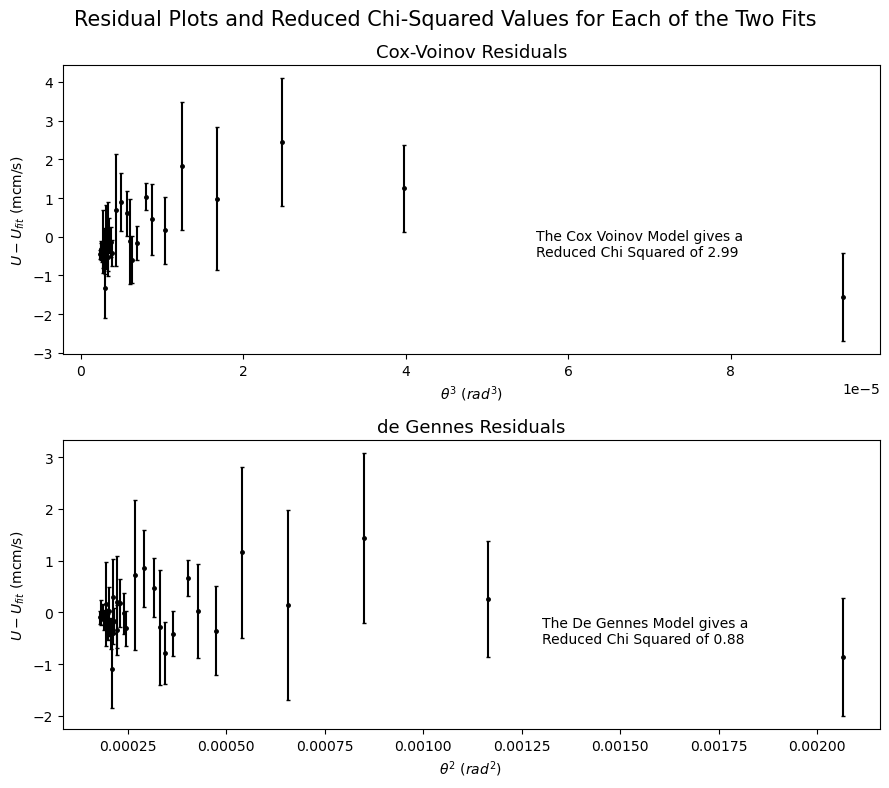

In [23]:
def Red_Chi_Sqrd (y, err_y, y_fit):
    """
    Calculates the reduced chi_squared of a data-set y with errors err_y relative to a fit with 2 parameters, y_fit.
    
    Arguments:
        y (np array of floats)
        err_y (np array of floats)
        y_fit (np array of floats)
    """
    return sum(((y - y_fit) / err_y) ** 2) / (len(y) - 2)

#calculating reduced chi squared's
cox_voinov_chi_sqrd = Red_Chi_Sqrd(U_mean, U_std, cox_voinov[0])
de_gennes_chi_sqrd = Red_Chi_Sqrd(U_mean, U_std, de_gennes[0])

#Caclulating residuals
cox_voinov_res = U_mean - cox_voinov[0]
de_gennes_res = U_mean - de_gennes[0]

#Plotting Residual Plots
plt.rcParams["figure.figsize"] = (9, 8)
figure = plt.figure()
figure.suptitle('Residual Plots and Reduced Chi-Squared Values for Each of the Two Fits', fontsize=15)

cox_voinov_res_plot = figure.add_subplot(211)
cox_voinov_res_plot.set_title(r'Cox-Voinov Residuals', fontsize=13)
cox_voinov_res_plot.set_xlabel(r'$\theta^{3} \ (rad^{3})$')
cox_voinov_res_plot.set_ylabel(r'$U - U_{fit}$ (mcm/s)')
cox_voinov_res_scatter = cox_voinov_res_plot.errorbar(theta_mean ** 3, cox_voinov_res, yerr=U_std, fmt='o', markersize=2.5, 
                                              color='black', linestyle='', capsize=1.5)
#adding the text containing the reduced chi squared value
cox_voinov_res_plot.text(5.6*10**(-5), -0.5, 'The Cox Voinov Model gives a \nReduced Chi Squared of {:.2f}'.format(
                     cox_voinov_chi_sqrd))

de_gennes_res_plot = figure.add_subplot(212)
de_gennes_res_plot.set_title(r'de Gennes Residuals', fontsize=13)
de_gennes_res_plot.set_xlabel(r'$\theta^{2} \ (rad^{2})$ ')
de_gennes_res_plot.set_ylabel(r'$U - U_{fit}$ (mcm/s)')
de_gennes_res_scatter = de_gennes_res_plot.errorbar(theta_mean ** 2, de_gennes_res, yerr=U_std, fmt='o', markersize=2.5, 
                                            color='black', linestyle='', capsize=1.5)
#adding the text containing the reduced chi squared value
de_gennes_res_plot.text(0.0013, -0.6, 'The De Gennes Model gives a \nReduced Chi Squared of {:.2f}'.format(de_gennes_chi_sqrd))

plt.tight_layout()
plt.show()

![](./img/bee.png)
## Drop Spreading Law Is

The results of the chi-squared analysis suggest that the De Gennes law is a better fit for the behaviour of the spreading drop. This is because it has a reduced chi squared value in the range 0.8 to 1.5, whereas for the Cox-Voinov model, the value falls significantly outside of this range.  Furthmore, when comparing the two residual plots, more points have error bars passing through $U - U_{fit}=0$ in the De Gennes plot than in the Cox-Voinov plot, indicating that for the errors estimated in this analysis, the De Genne's model more closely fits the data. 

It is also worth noting that the fit errors calculated for each trial  (the errors that one would expect if the data came from the assumed model) of both models is of the same order of magnitude as the errors in $U_{mean}$ (as can be seen below). This shows that both models are to some extent consistent with the data. However, as stated in the previous paragraph, the chi sqaured analysis indicates that the de Gennes model is the better fit.

The de Gennes model is typically observable at relatively low contact angles, implying that the contact angles present in this experiment are also "relatively low". Considering the magnitudes of the contact angles dealt with in this experiment (e.g. the $\theta_{0}$ values of order $10^{-2}$ rad calculated from both fits), this is consistent with what was calculated. 

In [24]:
def fit_error (y, y_fit):
    """
    Calculates the errors in y that one would expect if the data came from the assumed model
    
    Arguments:
        y (np array of floats)
        err_y (np array of floats)
        y_fit (np array of floats)
    """
    return np.sqrt(sum((y - y_fit)** 2) / (len(y) - 2))

cox_voinov_fit_err = fit_error(U_mean, cox_voinov[0])
de_gennes_fit_err = fit_error(U_mean, de_gennes[0])

print('\nThe fit error is {:.2f} for the Cox-Voinov model, and {:.2f} for the de Gennes model'.format(
      cox_voinov_fit_err, de_gennes_fit_err))


The fit error is 0.84 for the Cox-Voinov model, and 0.54 for the de Gennes model
